In [10]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

In [2]:
df = pd.read_csv('./data/InsNova_data_2023_train.csv')
df.drop(['id'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,driving_history_score,...,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,clm,numclaims,claimcst0
0,0.77,0.444504,SEDAN,4,M,D,3,petrol,147,67.0,...,S,1,weekday,6pm - 12am,6,640.448137,1.0,0,0,0.0
1,4.45,0.562183,STNWG,1,M,A,3,petrol,158,76.0,...,S,1,weekday,6am - 12pm,12,683.749691,0.0,0,0,0.0
2,4.90,0.465244,STNWG,1,F,A,3,petrol,159,58.0,...,M,1,weekday,6pm - 12am,6,653.656117,1.0,0,0,0.0
3,0.48,0.271039,PANVN,4,M,A,4,petrol,80,72.0,...,S,1,weekday,12pm - 6pm,12,642.574671,0.0,0,0,0.0
4,0.85,0.141624,SEDAN,4,F,A,5,petrol,126,91.0,...,S,0,weekday,6am - 12pm,6,647.175035,0.0,0,0,0.0


In [3]:
df_dummies = pd.get_dummies(df, columns=['veh_body', 'veh_age', 'gender', 'area', 'agecat', 'engine_type', 'veh_color', 'marital_status', 'e_bill', 'time_of_week_driven', 'time_driven', 'trm_len', 'high_education_ind'])

##### clm Model

In [4]:
clm_df = df_dummies.drop(columns=['numclaims', 'claimcst0'])

print(clm_df['clm'].value_counts())

clm
0    21077
1     1542
Name: count, dtype: int64


In [5]:
majority_class = clm_df[clm_df['clm'] == 0]
minority_class = clm_df[clm_df['clm'] == 1]

print(majority_class.shape)
print(minority_class.shape)

(21077, 64)
(1542, 64)


In [6]:
oversampled_minority = resample(minority_class, replace=True, n_samples=len(majority_class))

oversampled_minority.shape

(21077, 64)

In [7]:
clm_balanced_df = pd.concat([majority_class, oversampled_minority])
clm_balanced_df = clm_balanced_df.sample(frac=1)
clm_balanced_df.reset_index(drop=True, inplace=True)

In [8]:
clm_x, clm_y = clm_balanced_df.drop(columns=['clm']), clm_balanced_df['clm']

print(clm_x.shape, clm_y.shape)

(42154, 63) (42154,)


In [12]:
clm_x_train, clm_x_test, clm_y_train, clm_y_test = train_test_split(clm_x, clm_y, test_size=1 / 3)
clm_x_train, clm_x_val, clm_y_train, clm_y_val = train_test_split(clm_x_train, clm_y_train, test_size=1 / 3)

print(clm_x_train.shape, clm_x_val.shape, clm_x_test.shape, clm_y_train.shape, clm_y_val.shape, clm_y_test.shape)

(18734, 63) (9368, 63) (14052, 63) (18734,) (9368,) (14052,)


In [11]:
all_combos = []

for n_estimators in [5, 10, 15, 20, 25, 50, 100, 200, 300]:
    for min_samples_leaf in [5, 10, 15, 20, 25, 50]:
        for max_depth in [3, 4, 5, 6, 7, 8, 9, 10, 15, 20]:
            for min_samples_split in [2, 3, 4, 5, 10, 15]:
                for learning_rate in [0.01, 0.1, 0.2]:
                    all_combos.append((n_estimators, min_samples_leaf, max_depth, min_samples_split, learning_rate))

percentage_to_try = 0.01
n_runs = int(percentage_to_try * len(all_combos))
combos_to_try = random.sample(all_combos, n_runs)
print(f'Num runs: {n_runs}')

best_test_accuracy, clm_model = -np.inf, None

for n_estimators, min_samples_leaf, max_depth, min_samples_split, learning_rate in combos_to_try:
    curr_model = GradientBoostingClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_depth=max_depth, min_samples_split=min_samples_split, learning_rate=learning_rate)
    curr_model.fit(clm_x_train, clm_y_train)

    clm_y_train_pred = curr_model.predict(clm_x_train)
    clm_y_test_pred = curr_model.predict(clm_x_test)

    train_accuracy = accuracy_score(clm_y_train, clm_y_train_pred)
    test_accuracy = accuracy_score(clm_y_test, clm_y_test_pred)

    if test_accuracy > best_test_accuracy:
        best_test_accuracy, clm_model = test_accuracy, curr_model
        print(f'Best results so far: train = {train_accuracy}, test = {test_accuracy}')

        # Early stopping
        if best_test_accuracy >= 0.99:
            break

    n_runs -= 1
    print(f'Remaining runs: {n_runs}')

print(best_test_accuracy)
print(clm_model.get_params())

Num runs: 97
Best results so far: train = 0.7824276716131099, test = 0.7481497295758611
Remaining runs: 96
Remaining runs: 95
Remaining runs: 94
Remaining runs: 93
Remaining runs: 92
Best results so far: train = 0.999786484466745, test = 0.967904924565898
Remaining runs: 91
Remaining runs: 90


KeyboardInterrupt: 

In [13]:
space = {'max_depth': hp.quniform('max_depth', 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.uniform('n_estimators', 5, 500)
        }

def objective(space):
    clf = xgb.XGBRegressor(n_estimators=int(space['n_estimators']), max_depth=int(space['max_depth']), gamma=space['gamma'],
                           reg_alpha=int(space['reg_alpha']), min_child_weight=int(space['min_child_weight']),
                           colsample_bytree=int(space['colsample_bytree']), objective='reg:logistic')
    
    evaluation = [(clm_x_val, clm_y_val)]
    
    clf.fit(clm_x_train, clm_y_train, eval_set=evaluation, early_stopping_rounds=100, verbose=False)
    
    pred = clf.predict(clm_x_test) >= 0.5

    # loss = accuracy_score(clm_y_test, pred)

    # print(f'Test loss: {loss}')

    # return {'loss': -loss, 'status': STATUS_OK }

    try:
        loss = accuracy_score(clm_y_test, pred)

        print(f'Test loss: {loss}')

        return {'loss': -loss, 'status': STATUS_OK }
    
    except:
        print('here')
        return {'loss': np.inf, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

print(f'Best hyperparameters: \n{best_hyperparams}')

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

Test loss: 0.6073868488471392                          
Test loss: 0.6008397381155708                                                     
Test loss: 0.6040421292342727                                                     
Test loss: 0.6083831483062909                                                     
Test loss: 0.6126530031312268                                                     
Test loss: 0.6069598633646456                                                     
Test loss: 0.6058212354113294                                                     
Test loss: 0.622046683746086                                                      
Test loss: 0.6040421292342727                                                     
Test loss: 0.6058212354113294                                                    
Test loss: 0.6083831483062909                                                     
Test loss: 0.6058212354113294                                                     
Test loss: 0.6213350412752633   

KeyboardInterrupt: 

In [27]:
# params = {'colsample_bytree': 0.8180099505659084, 'gamma': 1.0643130726713133, 'max_depth': 16.0, 'min_child_weight': 9.0, 'n_estimators': 485.8553449406332, 'reg_alpha': 40.0, 'reg_lambda': 0.8070198480292471}
# params['max_depth'] = int(params['max_depth'])
# params['min_child_weight'] = int(params['min_child_weight'])
# params['n_estimators'] = int(params['n_estimators'])
# params['reg_alpha'] = int(params['reg_alpha'])
# params['objective'] = 'reg:logistic'
# clm_model = xgb.XGBRegressor(**params)
# clm_model.fit(clm_x_train, clm_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8180099505659084, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.0643130726713133, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=16,
             max_leaves=None, min_child_weight=9, missing=nan,
             monotone_constraints=None, n_estimators=485, n_jobs=None,
             num_parallel_tree=None, objective='reg:logistic', predictor=None, ...)

In [29]:
pred = clm_model.predict(clm_x_test) >= 0.5
accuracy_score(clm_y_test, pred)

0.7847281525761457

In [32]:
all_preds = clm_model.predict(clm_df.drop(columns=['clm'])) >= 0.5

print(np.unique(all_preds, return_counts=True))
print(clm_df['clm'].value_counts())

(array([False,  True]), array([16180,  6439]))
clm
0    21077
1     1542
Name: count, dtype: int64


##### numclaims model

In [14]:
num_claims_df = df_dummies.drop(columns=['clm', 'claimcst0'])

num_claims_df['numclaims'].value_counts()

numclaims
0    21077
1     1439
2       94
3        9
Name: count, dtype: int64

In [15]:
majority_class = num_claims_df[num_claims_df['numclaims'] == 0]
minority_class_1 = num_claims_df[num_claims_df['numclaims'] == 1]
minority_class_2 = num_claims_df[num_claims_df['numclaims'] == 2]
minority_class_3 = num_claims_df[num_claims_df['numclaims'] == 3]

print(majority_class.shape)
print(minority_class_1.shape)
print(minority_class_2.shape)
print(minority_class_3.shape)

(21077, 64)
(1439, 64)
(94, 64)
(9, 64)


In [16]:
oversampled_minority_1 = resample(minority_class_1, replace=True, n_samples=len(majority_class))
oversampled_minority_2 = resample(minority_class_2, replace=True, n_samples=len(majority_class))
oversampled_minority_3 = resample(minority_class_3, replace=True, n_samples=len(majority_class))

print(oversampled_minority_1.shape)
print(oversampled_minority_2.shape)
print(oversampled_minority_3.shape)

(21077, 64)
(21077, 64)
(21077, 64)


In [17]:
num_claims_balanced_df = pd.concat([majority_class, oversampled_minority_1, oversampled_minority_2, oversampled_minority_3])
num_claims_balanced_df = num_claims_balanced_df.sample(frac=1)
num_claims_balanced_df.reset_index(drop=True, inplace=True)

num_claims_balanced_df.shape

(84308, 64)

In [18]:
num_claims_x, num_claims_y = num_claims_balanced_df.drop(columns=['numclaims']), num_claims_balanced_df['numclaims']

print(num_claims_x.shape, num_claims_y.shape)

(84308, 63) (84308,)


In [19]:
num_claims_x_train, num_claims_x_test, num_claims_y_train, num_claims_y_test = train_test_split(num_claims_x, num_claims_y, test_size=1 / 3)
num_claims_x_train, num_claims_x_val, num_claims_y_train, num_claims_y_val = train_test_split(num_claims_x_train, num_claims_y_train, test_size=1 / 3)

print(num_claims_x_train.shape, num_claims_x_val.shape, num_claims_x_test.shape, num_claims_y_train.shape, num_claims_y_val.shape, num_claims_y_test.shape)

(37470, 63) (18735, 63) (28103, 63) (37470,) (18735,) (28103,)


In [20]:
space = {'max_depth': hp.quniform('max_depth', 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.uniform('n_estimators', 5, 500),
        'tweedie_variance_power': hp.uniform('tweedie_variance_power', 1, 2)
        }

def objective(space):
    power = space['tweedie_variance_power']

    clf = xgb.XGBRegressor(n_estimators=int(space['n_estimators']), max_depth=int(space['max_depth']), gamma=space['gamma'],
                           reg_alpha=int(space['reg_alpha']), min_child_weight=int(space['min_child_weight']),
                           colsample_bytree=int(space['colsample_bytree']), objective='reg:tweedie', tweedie_variance_power=power)
    
    evaluation = [(num_claims_x_train, num_claims_y_train), (num_claims_x_val, num_claims_y_val)]
    
    clf.fit(num_claims_x_train, num_claims_y_train, eval_set=evaluation, early_stopping_rounds=100, verbose=False)
    

    pred = clf.predict(num_claims_x_test)

    try:
        # pred = np.clip(pred, a_min=0, a_max=None)
        # loss = tweedie_loss(y_test, pred, power)
        loss = mean_squared_error(num_claims_y_test, pred)

        print(f'Test loss: {loss}')

        return {'loss': loss, 'status': STATUS_OK }
    
    except:
        return {'loss': np.inf, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

print(f'Best hyperparameters: \n{best_hyperparams}')

Test loss: 0.10956342182033899                         
Test loss: 0.11052146920544302                                                    
Test loss: 0.13748135363514838                                                    
Test loss: 0.10040556184421702                                                    
Test loss: 0.13081125291720178                                                    
Test loss: 0.0881548858106303                                                     
Test loss: 0.1639894841113023                                                     
Test loss: 0.11344351499730741                                                   
Test loss: 0.12920616060158988                                                   
Test loss: 0.11016853604392085                                                   
Test loss: 0.10817553786503083                                                    
Test loss: 0.10832634493197686                                                    
Test loss: 0.11670937844549713    

In [21]:
params = {'colsample_bytree': 0.9549427100408518, 'gamma': 1.531490222686555, 'max_depth': 17.0, 'min_child_weight': 2.0, 'n_estimators': 328.50293938973755, 'reg_alpha': 46.0, 'reg_lambda': 0.006139409044508717, 'tweedie_variance_power': 1.8646542717837375}
params['max_depth'] = int(params['max_depth'])
params['min_child_weight'] = int(params['min_child_weight'])
params['n_estimators'] = int(params['n_estimators'])
params['reg_alpha'] = int(params['reg_alpha'])
params['objective'] = 'reg:tweedie'
power = params['tweedie_variance_power']
num_claims_model = xgb.XGBRegressor(**params)
num_claims_model.fit(num_claims_x_train, num_claims_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9549427100408518, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.531490222686555, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=17,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, n_estimators=328, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', predictor=None, ...)

In [22]:
pred = num_claims_model.predict(num_claims_x_test)
mean_squared_log_error(num_claims_y_test, pred)

0.01161597806028189

##### cost Model

In [31]:
cost_df = df_dummies.drop(columns=['clm', 'numclaims'])

In [33]:
# Learn on the impure num claims data
num_claims_preds = num_claims_model.predict(cost_df.drop(columns=['claimcst0']))
assert len(num_claims_preds) == len(cost_df)
cost_df['numclaims'] = num_claims_preds

In [34]:
majority_class = cost_df[cost_df['claimcst0'] == 0]
minority_class = cost_df[cost_df['claimcst0'] != 0]

print(majority_class.shape)
print(minority_class.shape)

(21077, 65)
(1542, 65)


In [35]:
oversampled_minority = resample(minority_class, replace=True, n_samples=len(majority_class))

oversampled_minority.shape

(21077, 65)

In [36]:
cost_balanced_df = pd.concat([majority_class, oversampled_minority])
cost_balanced_df = cost_balanced_df.sample(frac=1)
cost_balanced_df.reset_index(drop=True, inplace=True)

cost_balanced_df[cost_balanced_df['claimcst0'] == 0].shape

(21077, 65)

In [37]:
cost_x, cost_y = cost_balanced_df.drop(columns=['claimcst0']), cost_balanced_df['claimcst0']

In [38]:
x_train, x_test, y_train, y_test = train_test_split(cost_x, cost_y, test_size=1 / 3)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1 / 3)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(18734, 64) (18734,) (9368, 64) (9368,) (14052, 64) (14052,)


In [39]:
space = {'max_depth': hp.quniform('max_depth', 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.uniform('n_estimators', 5, 500),
        'tweedie_variance_power': hp.uniform('tweedie_variance_power', 1, 2)
        }

def objective(space):
    power = space['tweedie_variance_power']

    clf = xgb.XGBRegressor(n_estimators=int(space['n_estimators']), max_depth=int(space['max_depth']), gamma=space['gamma'],
                           reg_alpha=int(space['reg_alpha']), min_child_weight=int(space['min_child_weight']),
                           colsample_bytree=int(space['colsample_bytree']), objective='reg:tweedie', tweedie_variance_power=power)
    
    evaluation = [(x_train, y_train), (x_val, y_val)]
    
    clf.fit(x_train, y_train, eval_set=evaluation, early_stopping_rounds=100, verbose=False)
    

    pred = clf.predict(x_test)

    try:
        loss = mean_squared_log_error(y_test, pred)

        print(f'Test loss: {loss}')

        return {'loss': loss, 'status': STATUS_OK }
    
    except:
        return {'loss': np.inf, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

print(f'Best hyperparameters: \n{best_hyperparams}')

Test loss: 3.121907530584813                           
Test loss: 2.3903727713796434                                                   
Test loss: 15.279686535868855                                                    
Test loss: 1.580606209756158                                                     
Test loss: 14.44633011795658                                                     
Test loss: 5.133898179780475                                                    
Test loss: 4.23363280074671                                                     
Test loss: 9.1027925031824                                                      
Test loss: 1.750025499282127                                                    
Test loss: 14.653343969484354                                                   
Test loss: 1.9649807200693572                                                    
Test loss: 4.709625852000694                                                     
Test loss: 6.868266042631986                    

In [40]:
params = {'colsample_bytree': 0.805489057457027, 'gamma': 3.7512949147285575, 'max_depth': 14.0, 'min_child_weight': 2.0, 'n_estimators': 484.51694842102376, 'reg_alpha': 101.0, 'reg_lambda': 0.29574903970770366, 'tweedie_variance_power': 1.0127779031760553}
params['max_depth'] = int(params['max_depth'])
params['min_child_weight'] = int(params['min_child_weight'])
params['n_estimators'] = int(params['n_estimators'])
params['reg_alpha'] = int(params['reg_alpha'])
params['objective'] = 'reg:tweedie'
power = params['tweedie_variance_power']
cost_model = xgb.XGBRegressor(**params)
cost_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.805489057457027, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=3.7512949147285575, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, n_estimators=484, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', predictor=None, ...)

In [41]:
pred = cost_model.predict(x_test)
mean_squared_log_error(y_test, pred)

0.2633299709330187

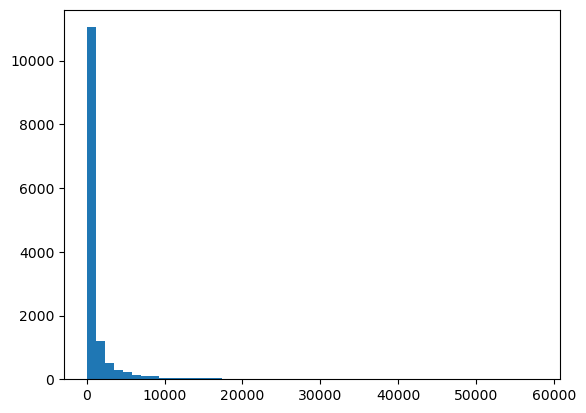

In [45]:
plt.hist(pred, bins=50)
plt.show()

##### Validation Predictons

In [46]:
val_df = pd.read_csv('./data/InsNova_data_2023_vh.csv')
ids = val_df['id']
val_df.drop(['id'], axis=1, inplace=True)
val_df.reset_index(drop=True, inplace=True)

val_df.head()

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,driving_history_score,veh_color,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind
0,3.40,0.076279,STNWG,2,M,B,4,petrol,174,83,black,S,1,weekday,6pm - 12am,6,648.247594,0
1,2.55,0.093443,STNWG,2,F,A,3,petrol,181,65,yellow,M,0,weekday,12am - 6 am,12,637.752677,0
2,3.04,0.157762,STNWG,2,F,E,4,petrol,136,64,white,S,1,weekday,12pm - 6pm,12,661.483786,0
3,2.05,0.560735,MIBUS,4,M,C,6,dissel,164,82,gray,M,1,weekday,6am - 12pm,12,647.846365,0
4,1.93,0.258275,HBACK,2,M,C,4,dissel,89,48,black,S,0,weekday,6am - 12pm,12,640.257550,0


In [47]:
val_df_dummies = pd.get_dummies(val_df, columns=['veh_body', 'veh_age', 'gender', 'area', 'agecat', 'engine_type', 'veh_color', 'marital_status', 'e_bill', 'time_of_week_driven', 'time_driven', 'trm_len', 'high_education_ind'])
val_df_dummies = val_df_dummies.rename(columns={'high_education_ind_0': 'high_education_ind_0.0', 'high_education_ind_1': 'high_education_ind_1.0'})

In [48]:
val_df_dummies['numclaims'] = num_claims_model.predict(val_df_dummies)

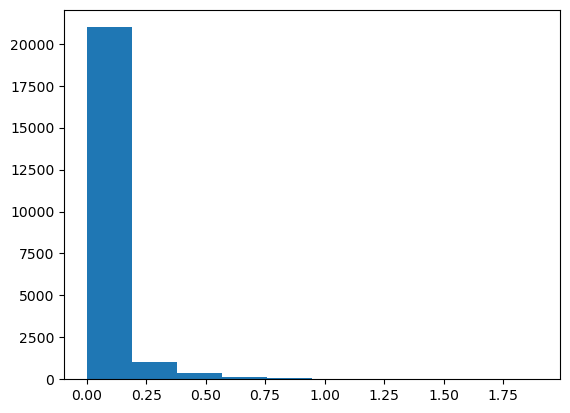

In [49]:
plt.hist(val_df_dummies['numclaims'])
plt.show()

2.9297384e-11
2408.1428
1.1419866e-08
10.456493


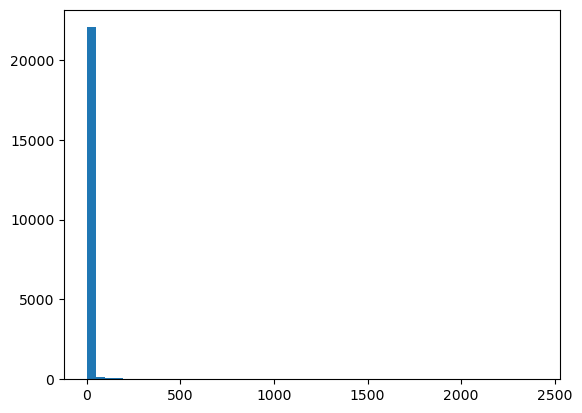

In [56]:
predicted_costs = cost_model.predict(val_df_dummies)

print(predicted_costs.min())
print(predicted_costs.max())
print(np.median(predicted_costs))
print(predicted_costs.mean())

# plt.hist(df['claimcst0'], bins=50)
plt.hist(predicted_costs, bins=50)
plt.show()

In [57]:
submission_df = pd.DataFrame({'id': ids, 'Predict': predicted_costs.reshape(-1,)})
submission_df.head()

,id,Predict
0,1,2.660214e-08
1,2,2.459705e-08
2,3,1.356506e-08
3,4,2.039466e-08
4,5,1.974446e-08


In [58]:
submission_df.to_csv('./data/submission.csv', index=False)